In [49]:
%config Application.log_level="INFO"

In [71]:
import requests
import time
import statistics
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib as mpl
from retry import retry

# Set DPI for print and civilised computers:
mpl.rcParams['figure.dpi']= "300"

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')

# Get the IP number of the master
MASTER_IP = ! openstack stack output show \
    project-group-x-stack \
    master_instance_floating_ip \
    --format=value \
    --column=output_value

MASTER_IP = MASTER_IP[0]
#MASTER_IP = "127.0.0.1"
PORT_NR = 80
API_BASE_URL = "http://{}:{}".format(MASTER_IP, PORT_NR)
POLL_INTERVAL_S = 0.1

print(API_BASE_URL)

http://130.238.29.80:80


In [51]:
import logging
log = logging.getLogger()
log.setLevel(logging.INFO)

## Calling the API from Python


The following sequence illustrates how to make a blocking call to the asynchronous API using Python and requests:

In [52]:
@retry(delay=1, backoff=2, max_delay=4, logger=log)
def submit_experiment(**kwargs):
    session = requests.Session()
    job = session.post("{}/experiments".format(API_BASE_URL), json=kwargs)
    job.raise_for_status()
    return job.url

@retry(delay=1, backoff=2, max_delay=4, logger=log)            
def get_status(job_callback_url, session=None):
    session = requests.Session() if not session else session
    res = session.get(job_callback_url)
    res.raise_for_status()
    return res.json()

def poll_job(job_callback_url):
    session = requests.Session()
    job_status = get_status(job_callback_url, session)
    
    while job_status['status'] != 'COMPLETED':
        job_status = get_status(job_callback_url, session)
        time.sleep(POLL_INTERVAL_S)
    return job_status

In [53]:
def runtimes(results):
    return [result['runtime'] for result in results]

In [54]:
@retry(delay=1, backoff=2, max_delay=4, logger=log)
def get_nr_workers():
    return int(requests.get("{}/config/workers".format(API_BASE_URL)).json())

In [72]:
NR_WORKERS = get_nr_workers()
NR_WORKERS

10

## Performance Benchmark

In [75]:
WORKERS_RANGE = [3, 6, 10]
SCALE_PER_WORKER = 25
START_SCALE = 25
# Repeat each experiment:
NR_SAMPLES = 1

def set_nr_workers(n):
    try:
        res = requests.put("{}/config/workers/{}"
                            .format(API_BASE_URL, n))
        res.raise_for_status()
    except Exception:
        #print("Warning! Problem setting workers to {}"
        #      .format(n))
        # This is a really cheap and dirty retry logic
        set_nr_workers(n)

def run_benchmark(nr_workers, nr_jobs):
    set_nr_workers(nr_workers)
    time.sleep(0.5) # Wait for things to settle
    
    def do_measure():
        start_time = time.time()
        
        urls = [submit_experiment(
                    benchmarks=["IJCAR2018/div.c.50.smt2"],
                    timeout=60,
                    approximations=["ijcar"],
                    solvers=["backeman/uppsat:z3"]) 
                for _ in range(nr_jobs)]
        
        # Wait for jobs to finish
        trial_runtimes = sum([runtimes(poll_job(url)['results']) 
                              for url in urls], [])
        
        return (time.time() - start_time, trial_runtimes)
    
    results = [do_measure() for _ in range(NR_SAMPLES)]
    
    #print("Variance was: {}".format(
    #    statistics.variance(results)))
    (runtime, solver_runtimes) = zip(*results)
    
    # Flatten any repeated solver runtime trials
    solver_runtimes = sum(list(solver_runtimes), []) 
    log.info("Workers: {}, nr jobs: {} had runtime {}".format(nr_workers, nr_jobs, runtime))
    log.info("Solver runtimes were: {}".format(solver_runtimes))
    return (statistics.mean(runtime), solver_runtimes)

def scale_workload(nr_workers):
    return START_SCALE + (nr_workers * SCALE_PER_WORKER)

In [76]:
weak_scaling_runtimes = list(zip(*[run_benchmark(
                                nr_workers, 
                                nr_jobs=scale_workload(nr_workers))
                                    for nr_workers in WORKERS_RANGE]))[0]

INFO:root:Workers: 3, nr jobs: 100 had runtime (685.5195529460907,)
INFO:root:Solver runtimes were: [12.746409, 13.007553, 10.713669, 12.831087, 12.803753, 10.672584, 12.684033, 12.962419, 10.738314, 12.900184, 12.883616, 10.513263, 13.285624, 13.015837, 10.497741, 10.666646, 12.848402, 10.858152, 12.85959, 12.844902, 10.696992, 12.975189, 12.876902, 10.966512, 12.714862, 13.096567, 10.777744, 10.614213, 12.810461, 12.784271, 10.782162, 12.666001, 13.065979, 10.855041, 13.058127, 12.855634, 10.748496, 13.014539, 12.799028, 10.495398, 12.820024, 10.41349, 12.737435, 10.668724, 12.871984, 13.279954, 10.77609, 13.027452, 13.18562, 10.66696, 13.038948, 13.086042, 10.542482, 12.830112, 12.962596, 10.98236, 13.071856, 12.971183, 10.489828, 12.79316, 10.952012, 12.966054, 12.733784, 10.584629, 12.872149, 10.660421, 12.935477, 13.292501, 10.872264, 12.960728, 12.984638, 10.665671, 13.038817, 12.950014, 10.730127, 13.004591, 10.637525, 13.118511, 10.840213, 12.975641, 12.843934, 10.588726, 12.8

In [78]:
STRONG_SCALING_NR_JOBS = 75
strong_scaling_runtimes, solve_times = zip(*[
        run_benchmark(nr_workers, nr_jobs=STRONG_SCALING_NR_JOBS)
            for nr_workers in WORKERS_RANGE])

INFO:root:Workers: 3, nr jobs: 75 had runtime (488.6335859298706,)
INFO:root:Solver runtimes were: [10.998922, 12.801097, 12.791615, 10.610974, 13.01019, 12.809041, 10.703941, 13.157239, 12.822255, 10.890382, 13.021043, 12.78155, 10.712486, 12.928672, 13.018962, 10.608711, 12.95742, 13.065117, 10.722063, 12.753066, 12.939123, 10.817859, 13.01793, 12.808896, 10.475714, 12.765707, 13.049903, 10.80702, 13.030968, 13.202936, 10.597424, 13.007623, 13.054785, 10.708568, 12.82054, 12.889762, 10.757761, 10.740673, 13.171926, 10.853961, 12.949506, 12.935997, 10.550047, 12.874324, 13.133414, 10.523706, 12.849165, 13.114577, 10.865467, 12.927458, 12.721686, 10.761153, 13.036487, 12.859415, 10.573514, 13.249577, 10.74696, 12.858541, 12.692068, 10.741642, 13.028775, 10.834405, 12.828845, 12.892785, 10.75418, 13.087136, 12.775679, 10.743338, 12.967423, 12.787349, 10.840594, 12.847553, 12.858795, 10.593532]
INFO:root:Workers: 6, nr jobs: 75 had runtime (253.91357517242432,)
INFO:root:Solver runtimes 

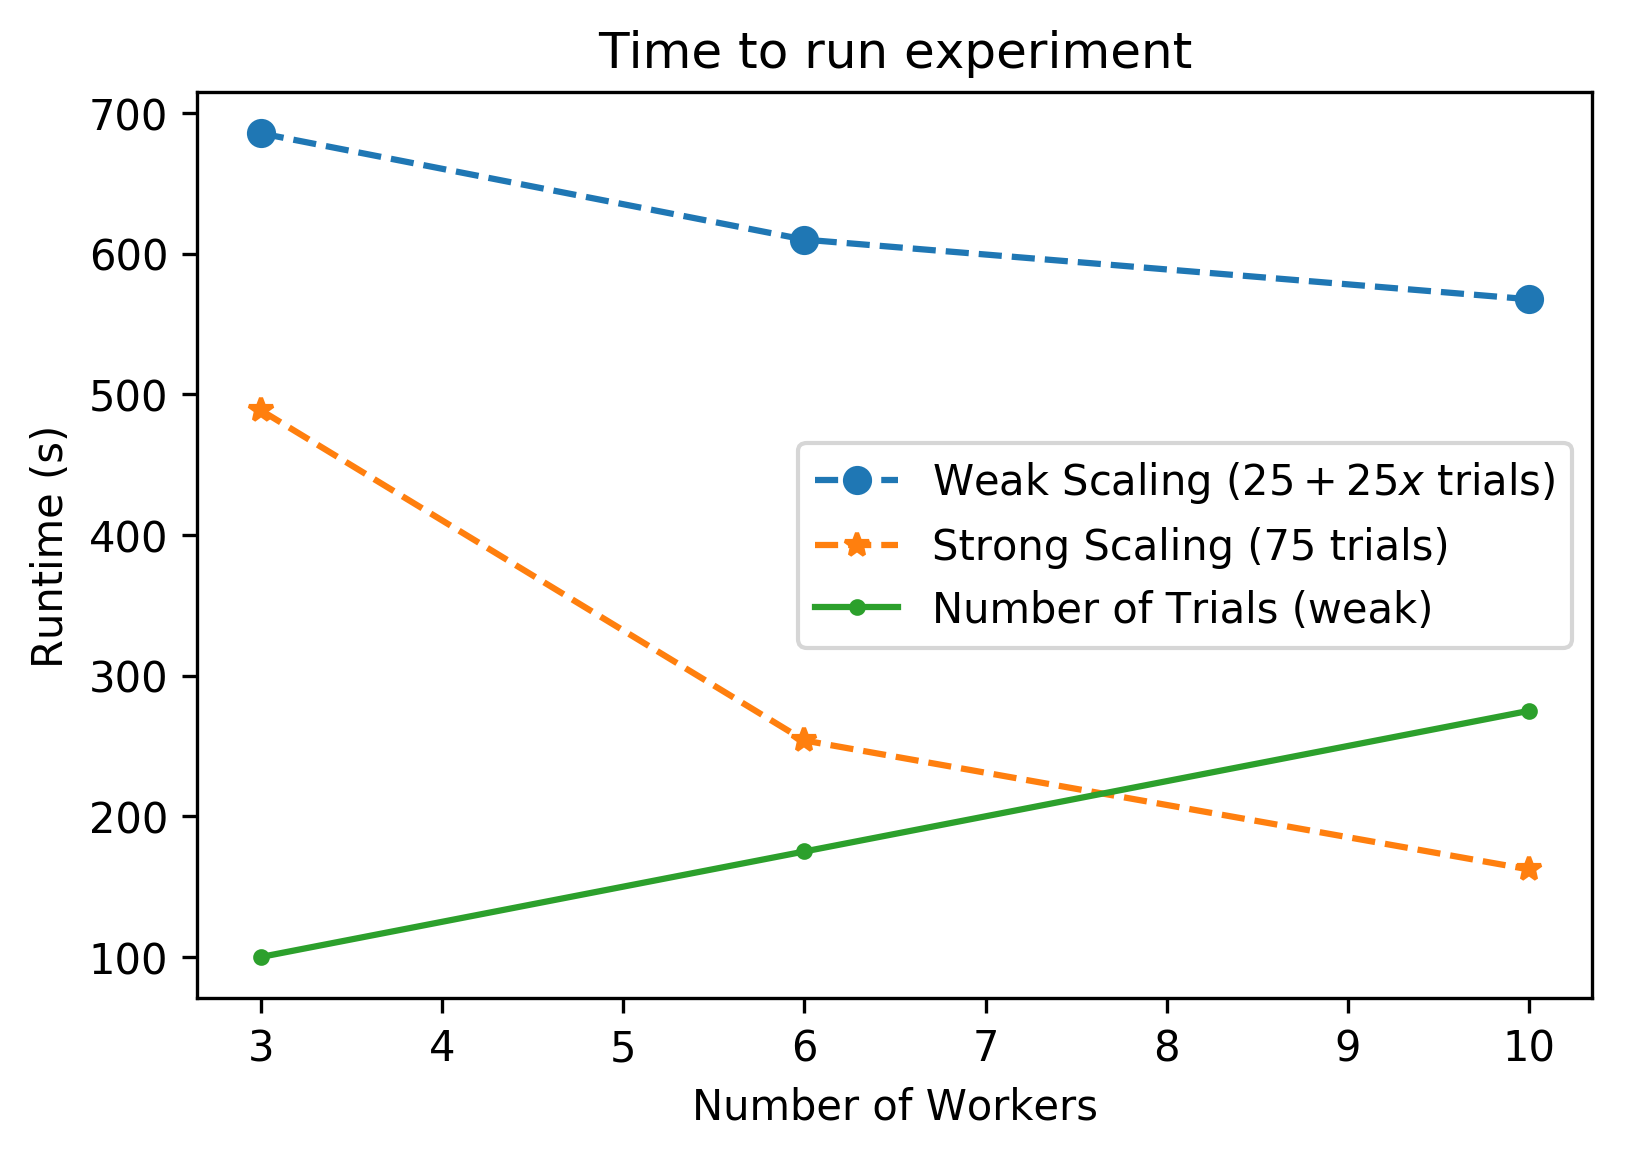

In [80]:
plt.plot(
    WORKERS_RANGE, 
    weak_scaling_runtimes,
    marker='o',
    linestyle='dashed',
    label=("Weak Scaling (${} +{}x$ trials)"
            .format(START_SCALE, SCALE_PER_WORKER)))

plt.plot(WORKERS_RANGE, 
         strong_scaling_runtimes,
         marker='*',
         linestyle='dashed',
         label="Strong Scaling ({} trials)".format(STRONG_SCALING_NR_JOBS))

plt.plot(WORKERS_RANGE, 
         [scale_workload(x) for x in WORKERS_RANGE],
         marker='.',
         linestyle=None,
         label="Number of Trials (weak)")

plt.ylabel('Runtime (s)')
plt.xlabel('Number of Workers')
plt.title("Time to run experiment")
plt.legend()
#plt.show()

In [81]:
plt.savefig("report/scaling_graph_large.pdf", bbox_inches='tight')

In [73]:
run_benchmark(10, nr_jobs=75)

INFO:root:Workers: 10, nr jobs: 75 had runtime (173.81087112426758,)
INFO:root:Solver runtimes were: [11.12016, 11.127212, 10.738174, 10.866049, 12.941988, 10.88504, 10.72012, 11.097706, 10.854487, 12.887262, 10.9213, 10.999912, 11.007923, 10.960814, 13.190431, 10.981762, 10.756671, 10.977246, 10.746134, 12.755326, 11.224002, 10.888313, 11.014604, 10.941427, 12.964769, 10.893745, 10.835296, 11.047429, 11.019524, 12.980569, 11.255728, 10.873956, 11.204098, 10.796291, 12.991094, 10.824723, 10.700861, 10.873086, 10.846583, 13.451294, 11.229731, 10.966059, 10.868901, 10.855607, 13.279743, 10.666427, 10.740615, 11.049006, 10.719352, 13.030856, 10.876534, 10.813442, 11.3603, 10.984451, 11.072435, 11.135532, 10.769194, 12.791007, 13.27653, 11.127958, 10.814736, 10.984181, 10.75741, 11.181355, 10.666305, 11.035452, 10.89126, 10.98842, 12.762803, 13.072067, 10.769247, 10.835968, 11.144901, 10.729464, 10.794614]


(173.81087112426758,
 [11.12016,
  11.127212,
  10.738174,
  10.866049,
  12.941988,
  10.88504,
  10.72012,
  11.097706,
  10.854487,
  12.887262,
  10.9213,
  10.999912,
  11.007923,
  10.960814,
  13.190431,
  10.981762,
  10.756671,
  10.977246,
  10.746134,
  12.755326,
  11.224002,
  10.888313,
  11.014604,
  10.941427,
  12.964769,
  10.893745,
  10.835296,
  11.047429,
  11.019524,
  12.980569,
  11.255728,
  10.873956,
  11.204098,
  10.796291,
  12.991094,
  10.824723,
  10.700861,
  10.873086,
  10.846583,
  13.451294,
  11.229731,
  10.966059,
  10.868901,
  10.855607,
  13.279743,
  10.666427,
  10.740615,
  11.049006,
  10.719352,
  13.030856,
  10.876534,
  10.813442,
  11.3603,
  10.984451,
  11.072435,
  11.135532,
  10.769194,
  12.791007,
  13.27653,
  11.127958,
  10.814736,
  10.984181,
  10.75741,
  11.181355,
  10.666305,
  11.035452,
  10.89126,
  10.98842,
  12.762803,
  13.072067,
  10.769247,
  10.835968,
  11.144901,
  10.729464,
  10.794614])

In [77]:
solve_times

([11.556165,
  11.444609,
  11.208008,
  11.148005,
  11.223646,
  11.178481,
  11.523566,
  11.445303,
  11.106584,
  11.182845,
  11.316497,
  11.292771,
  11.41921,
  11.40612,
  11.20714,
  11.36176,
  11.162453,
  11.381895,
  11.313781,
  11.414961,
  11.549099,
  11.387913,
  11.439292,
  11.435885,
  11.402982,
  11.616298,
  11.159906,
  11.476532,
  11.460318,
  11.826219,
  11.345874,
  11.413496,
  11.460593,
  11.347139,
  11.663125,
  11.311705,
  11.712123,
  11.71258,
  11.507527,
  11.521072,
  11.838699,
  11.615917,
  11.531195,
  11.469909,
  11.502841,
  11.44086,
  11.395154,
  11.539231,
  11.459227,
  11.406949,
  11.513646,
  11.309027,
  11.345577,
  11.467349,
  11.58964,
  11.398849,
  11.48416,
  11.609976,
  11.652471,
  11.528662,
  11.909984,
  11.399651,
  11.508528,
  11.538504,
  11.590886,
  11.643721,
  11.803533,
  11.407073,
  11.486105,
  11.640533,
  11.336839,
  11.754395,
  11.524815,
  11.477581,
  11.478894],
 [11.575807,
  11.227228,
  11.8